In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential

In [2]:
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
batch_size = 32
img_height = 224
img_width = 224

In [5]:
data_dir = 'data/dataset/'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 31476 files belonging to 126 classes.
Using 25181 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 31476 files belonging to 126 classes.
Using 6295 files for validation.


In [7]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [8]:
class_names = train_ds.class_names


In [9]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
num_classes = len(class_names)
IMG_SHAPE = (img_width, img_height, 3)

## ResNet


In [12]:

basemodel = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
basemodel.trainable = False
basemodel.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [13]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = basemodel(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [14]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

In [15]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = basemodel(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs,name = 'resnet_model')
model.summary()

Model: "resnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 126)              

In [16]:
lr = 0.001
b1 = 0.9
b2 = 0.999 
ep = 1e-07
EPOCHS = 8

In [17]:
checkpoint_filepath = 'models/checkpoints/resnet'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1=b1,beta_2=b2, epsilon=ep, decay=0.0),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [18]:

history = model.fit(
  train_ds,
  validation_data=val_ds,
      callbacks=[model_checkpoint_callback],
  epochs=EPOCHS
)

Epoch 1/8
787/787 [==============================] - 97s 119ms/step - loss: 1.3871 - accuracy: 0.6909 - val_loss: 0.5729 - val_accuracy: 0.8896
Epoch 2/8
787/787 [==============================] - 127s 162ms/step - loss: 0.4047 - accuracy: 0.9192 - val_loss: 0.3441 - val_accuracy: 0.9283
Epoch 3/8
787/787 [==============================] - 137s 174ms/step - loss: 0.2365 - accuracy: 0.9575 - val_loss: 0.2550 - val_accuracy: 0.9455
Epoch 4/8
787/787 [==============================] - 139s 177ms/step - loss: 0.1583 - accuracy: 0.9734 - val_loss: 0.2089 - val_accuracy: 0.9532
Epoch 5/8
787/787 [==============================] - 124s 158ms/step - loss: 0.1130 - accuracy: 0.9832 - val_loss: 0.1810 - val_accuracy: 0.9558
Epoch 6/8
787/787 [==============================] - 135s 172ms/step - loss: 0.0849 - accuracy: 0.9886 - val_loss: 0.1611 - val_accuracy: 0.9600
Epoch 7/8
787/787 [==============================] - 139s 176ms/step - loss: 0.0659 - accuracy: 0.9931 - val_loss: 0.1524 - val_acc

In [19]:
loss, accuracy = model.evaluate(test_dataset)
accuracy = accuracy * 100
print(f"Loss: {loss:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

39/39 [==============================] - 5s 103ms/step - loss: 0.1190 - accuracy: 0.9736
Loss: 0.12%
Accuracy: 97.36%


In [20]:
import datetime
today = datetime.datetime.now()
folder_name = f'{today.hour}-{today.minute}_{today.day:02d}-{today.month}-{today.year}'
path = os.path.join('results','model_summary','resnet',folder_name)
if not os.path.exists(path):
    os.makedirs(path)
model_folder = path

In [21]:
import pickle
pickle.dump(history.history, open(model_folder+'\history.pickle', 'wb'))

In [22]:
# save weights
model.save_weights(model_folder+f'/model_{num_classes}.h5')

In [23]:
model.save(model_folder+'\model')

INFO:tensorflow:Assets written to: results\model_summary\resnet\22-8_23-3-2022\model\assets


C:\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


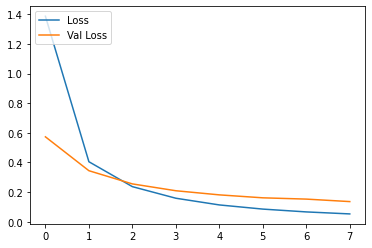

In [24]:
plt.plot(history.history['loss'],label="Loss")
plt.plot(history.history['val_loss'],label="Val Loss")
plt.legend(loc="upper left")
plt.savefig(model_folder+'\loss.png')
plt.show()

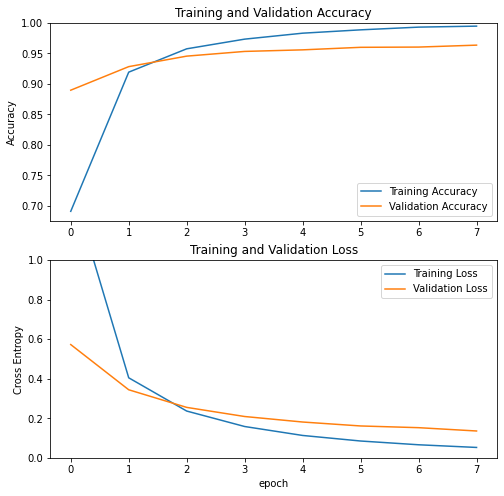

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(model_folder+'\\combined.png')
plt.show()

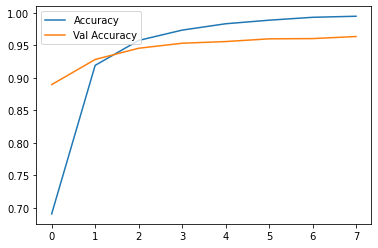

In [26]:
plt.plot(history.history['accuracy'],label="Accuracy")
plt.plot(history.history['val_accuracy'],label="Val Accuracy")
plt.legend(loc="upper left")
plt.savefig(model_folder+'\\accuracy.png')
plt.show()

### Fine tuning

In [27]:
# backup 
og_model = model

In [28]:
print("Number of layers in the base model: ", len(basemodel.layers))

Number of layers in the base model:  190


In [29]:
basemodel.trainable = True 

In [30]:
# Fine-tune from this layer onwards
fine_tune_at = 95

# Freeze all the layers before the `fine_tune_at` layer
for layer in basemodel.layers[:fine_tune_at]:
  layer.trainable =  False

In [31]:
lr = 1e-05
b1 = 0.9
b2 = 0.999 
ep = 1e-07

In [32]:

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1=b1,beta_2=b2, epsilon=ep, decay=0.0),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [33]:
model.summary()

Model: "resnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 126)              

In [34]:
fine_tune_epochs = 4 
total_epochs =  EPOCHS + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                        callbacks=[model_checkpoint_callback],
                         validation_data=val_ds)

Epoch 8/12
787/787 [==============================] - 207s 256ms/step - loss: 0.0307 - accuracy: 0.9913 - val_loss: 0.0595 - val_accuracy: 0.9830
Epoch 9/12
787/787 [==============================] - 183s 233ms/step - loss: 0.0145 - accuracy: 0.9956 - val_loss: 0.0766 - val_accuracy: 0.9762
Epoch 10/12
787/787 [==============================] - 193s 245ms/step - loss: 0.0111 - accuracy: 0.9967 - val_loss: 0.0299 - val_accuracy: 0.9927
Epoch 11/12
787/787 [==============================] - 194s 247ms/step - loss: 0.0095 - accuracy: 0.9969 - val_loss: 0.0252 - val_accuracy: 0.9921
Epoch 12/12
787/787 [==============================] - 198s 252ms/step - loss: 0.0079 - accuracy: 0.9971 - val_loss: 0.0461 - val_accuracy: 0.9859


In [35]:
model.load_weights(checkpoint_filepath)

In [36]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

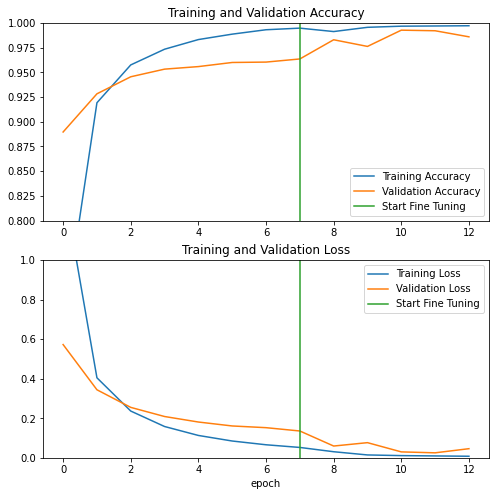

In [37]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(model_folder+'\\combined_finetuned.png')
plt.show()

In [38]:
loss_finetuned, accuracy_finetuned = model.evaluate(test_dataset)
accuracy_finetuned = accuracy_finetuned * 100
print('Test accuracy :', accuracy_finetuned)

39/39 [==============================] - 4s 99ms/step - loss: 0.0283 - accuracy: 0.9912 0s - loss: 0.0295 - accu
Test accuracy : 99.11859035491943


In [39]:
def predict_word(num):
    pred = ''
    ch = class_names[num]
    lis = ch.split(' ')
    char_list = [chr(int(i)) for i in lis]
    pred += ''.join(char_list)
    return pred

In [40]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

In [41]:
predictions = predictions.argmax(axis=-1)

In [42]:
from matplotlib.font_manager import FontProperties
from pathlib import Path
# point to the font location with an absolute path
nirm = Path('c:/Windows/Fonts/kartika.ttf')

# configure the Hindi font
mal_font = FontProperties(fname=nirm)

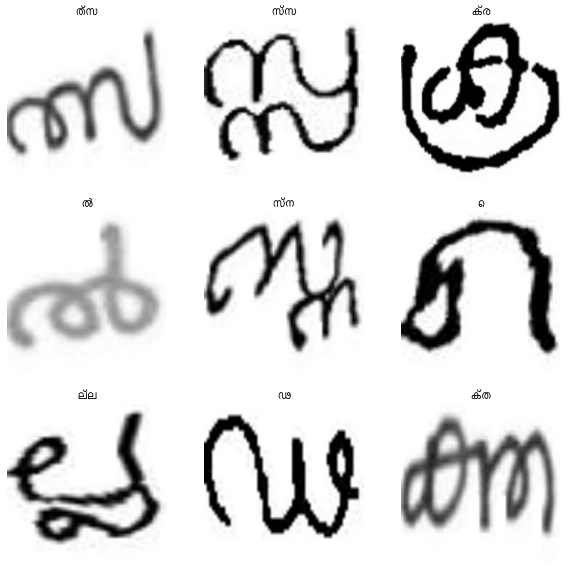

In [43]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    pred_word = predict_word(predictions[i])
    plt.title(pred_word, fontproperties=mal_font)
    plt.axis("off")

In [44]:
# save weights
model.save_weights(model_folder+f'/model_{num_classes}_resnet_finetuned_-acc{int(accuracy_finetuned)}.h5')

In [45]:
# save as directory
model.save(model_folder+f'\model_finetuned')

INFO:tensorflow:Assets written to: results\model_summary\resnet\22-8_23-3-2022\model_finetuned\assets


C:\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [46]:
classes = np.array(class_names)

In [47]:
with open(model_folder+'\class_names.npy', 'wb') as f:
    np.save(f, classes)

In [48]:
pickle.dump(history_fine.history, open(model_folder+'\history_fine.pickle', 'wb'))

In [49]:
f = open(model_folder+"\\config.txt", "w")
f.writelines([f'LR: {lr}\n',f'Beta 1:{b1}\n',f'Beta 2:{b2}\n',f'Classes: {num_classes}',f'epsilon:{ep}\n',f'epochs:{EPOCHS}\n',f'accuracy: {accuracy}\n',f'accuracy finetuned: {accuracy_finetuned}\n'])
f.close()